In [130]:
%pip install surprise

In [3]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = ':https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1636%2F792972%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241002%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241002T203159Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6e3fd2ab55c10ade0430f479818d966568b70e35de0322718acb5cdbbba6af25dff6c08b7109454a4f45e48dbf97f6a0d608bccb9ca474d8b0accfeb84f5e6f744f4bdb54fcb464358d6f267702d2c1fdbcd3c32b77c057fc67f09bc869ccac30b9baeff681366d101277d74af1224c869628c36c10d643ec6cdd62858eb38f1740320d26f02f0aa3aa2ffff5432cb41be65314f730f88f287d1703e8f40fd3ee4cb10024b7ef801b5780704a1b0f0bed181c9fcd59ff711f05e35bf240674b832a539c82f0b251b675b298a736cdb4e9e66d56cb7f75cb3d09c2789210730102395a17f7784c74a9c1c9a1f5c3c4d1fb5029fcd55f75b1cfa2337c8219a0ed4'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 716193814 bytes downloaded
Downloaded and uncompressed: 
Data source import complete.


Let's import the library we needed before we get started:

In [4]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
sns.set_style("darkgrid")

Next let's load first data file and get a feeling of how huge the dataset is:

In [5]:
def load_data(path):
    columns = ['Cust_Id', 'Rating', 'Date']
    df = pd.read_csv(path, header = None, names = columns)
    df['Rating'] = df['Rating'].astype(float)
    return df

In [6]:
df1 = load_data('../input/combined_data_1.txt')
df2 = load_data('../input/combined_data_2.txt')
df3 = load_data('../input/combined_data_3.txt')
df4 = load_data('../input/combined_data_4.txt')

In [7]:
df = pd.concat([df1, df2, df3, df4], axis=0, ignore_index=True)
print(f'Dataset shape: {df.shape}')

Dataset shape: (100498277, 3)


## Data viewing

In [8]:
df.isnull().sum()

,0
Cust_Id,0
Rating,17770
Date,17770


Let's give a first look on how the data spread:

<ipython-input-9-881a67ca2680>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  movie_count = df.isnull().sum()[1]
<ipython-input-9-881a67ca2680>:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')


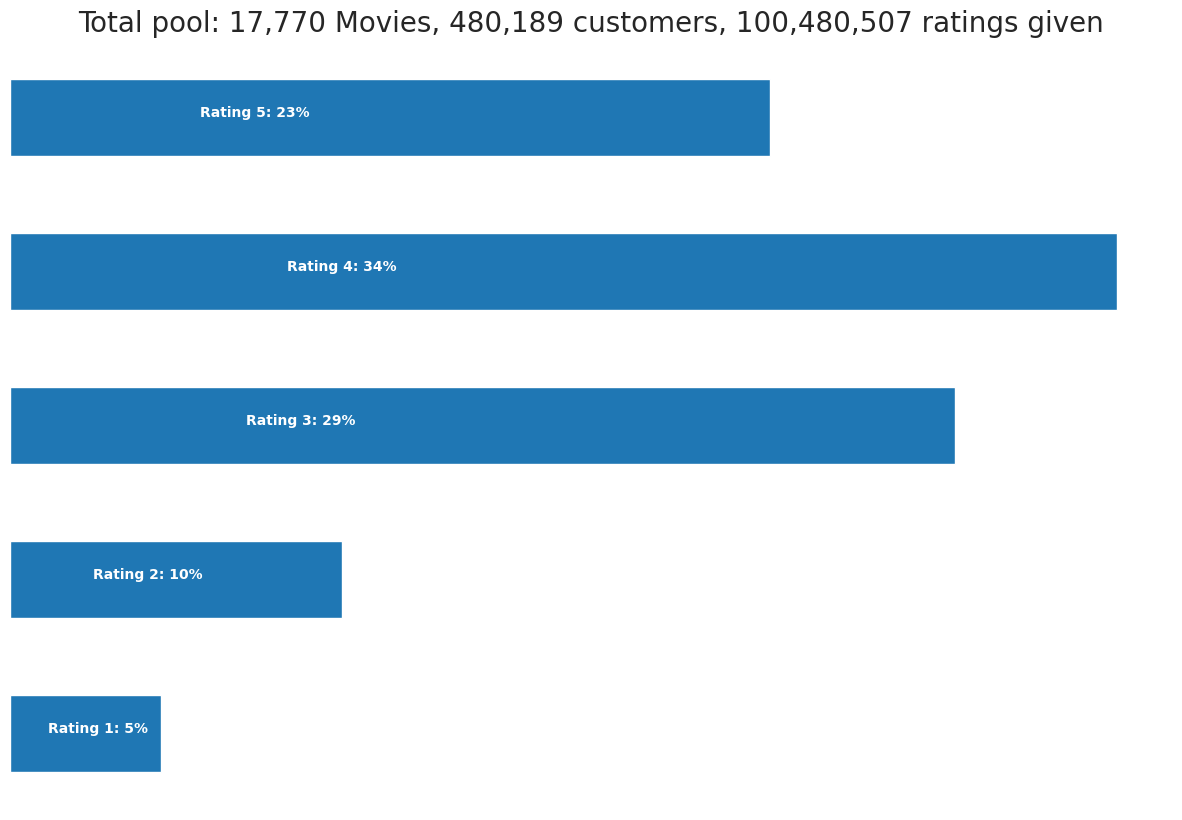

In [9]:
p = df.groupby('Rating')['Rating'].agg(['count'])

# get movie count
movie_count = df.isnull().sum()[1]

# get customer count
cust_count = df['Cust_Id'].nunique() - movie_count

# get rating count
rating_count = df['Cust_Id'].count() - movie_count

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')



We can see that the rating tends to be relatively positive (>3). This may be due to the fact that unhappy customers tend to just leave instead of making efforts to rate. We can keep this in mind - low rating movies mean they are generally really bad

## Data cleaning

Movie ID is really a mess import! Looping through dataframe to add Movie ID column WILL make the Kernel run out of memory as it is too inefficient. I achieve my task by first creating a numpy array with correct length then add the whole array as column into the main dataframe! Let's see how it is done below:

In [10]:
df['Movie_id'] = df['Rating'].isna().cumsum()
df.dropna(inplace = True)

In [11]:
df['Movie_id'] = df['Movie_id'].astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)

## Data slicing

The data set now is super huge. I have tried many different ways but can't get the Kernel running as intended without memory error. Therefore I tried to reduce the data volumn by improving the data quality below:

* Remove movie with too less reviews (they are relatively not popular)
* Remove customer who give too less reviews (they are relatively less active)

Having above benchmark will have significant improvement on efficiency, since those unpopular movies and non-active customers still occupy same volumn as those popular movies and active customers in the view of matrix (NaN still occupy space). This should help improve the statistical signifiance too.

Let's see how it is implemented:

In [123]:
drop_mov_index = df.Movie_id.value_counts()[df.Movie_id.value_counts()> round(df.Movie_id.value_counts().quantile(0.75),0)].index
drop_cust_index = df.Cust_Id.value_counts()[df.Cust_Id.value_counts()> round(df.Cust_Id.value_counts().quantile(0.75),0)].index

In [26]:
df_permanent = df.copy()

In [122]:
df = df_permanent.copy()

In [124]:
df = df[df.Movie_id.isin(drop_mov_index)]
df = df[df.Cust_Id.isin(drop_cust_index)]
df.reset_index(drop=True, inplace=True)

In [125]:
df.Movie_id.nunique()

4442

In [126]:
df.Cust_Id.nunique()

119759

In [127]:
df.shape

(64759225, 4)

In [128]:
64759225/100480507

0.6444954044668584

Now let's trim down our data, whats the difference in data size?

Let's pivot the data set and put it into a giant matrix - we need it for our recommendation system:

In [129]:
df.pivot_table(values='Rating', index='Cust_Id', columns='Movie_id', aggfunc='mean')

Movie_id,8,16,17,18,26,28,30,33,44,46,...,17724,17725,17730,17743,17756,17758,17761,17762,17764,17769
Cust_Id,,,,,,,,,,,,,,,,,,,,,
6,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,5.0,NaN,NaN,NaN,NaN,4.0,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2649336,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
2649378,NaN,NaN,NaN,NaN,NaN,3.0,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2649388,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN


## Data mapping

Now we load the movie mapping file:

In [153]:
df_title = pd.read_csv('movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_id', 'Year', 'Name'])
df_title.set_index('Movie_id', inplace = True)
print (df_title.head(10))

            Year                          Name
Movie_id                                      
1         2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW
6         1997.0                          Sick
7         1992.0                         8 Man
8         2004.0    What the #$*! Do We Know!?
9         1991.0      Class of Nuke 'Em High 2
10        2001.0                       Fighter


# Recommendation models

Well all data required is loaded and cleaned! Next let's get into the recommendation system.

## Recommend with Collaborative Filtering

## Recommend with Collaborative Filtering

In [146]:
df

,Cust_Id,Rating,Date,Movie_id
0,824097,2.0,2005-07-08,8
1,785314,1.0,2005-07-13,8
2,243963,3.0,2005-07-15,8
3,1447783,4.0,2005-07-19,8
4,1912665,1.0,2005-08-21,8
...,...,...,...,...
64759220,1428223,4.0,2005-02-01,17769
64759221,483107,4.0,2005-04-08,17769
64759222,77664,2.0,2005-09-16,17769
64759223,1922916,3.0,2005-10-19,17769


In [148]:
reader = Reader()

# get just top 100K rows for faster run time
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_id', 'Rating']][:1000000], reader)
#data.split(n_folds=3)

svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'])

{'test_rmse': array([0.95269963, 0.95261512, 0.95541624, 0.95561037, 0.95236159]),
 'test_mae': array([0.7492679 , 0.74912231, 0.75089136, 0.75005455, 0.7482037 ]),
 'fit_time': (13.871392250061035,
  14.004864931106567,
  14.429239511489868,
  14.079585552215576,
  14.316526412963867),
 'test_time': (1.2639670372009277,
  1.1548123359680176,
  1.1858108043670654,
  1.1542179584503174,
  1.1717467308044434)}